**WINE DATA ANYLYSIS**

Dataset from: https://archive.ics.uci.edu/ml/datasets/Wine

**INTRO**

We will be using the dataset "wine", from the url: https://archive.ics.uci.edu/ml/datasets/wine/wine.data


The "wine" dataset contains the data of 13 attributes of wines, created from the same region of Italy, created from 3 different cultivars (cultivar 1, 2, and 3). A cultivar is a plant or fruit variety that has been cultivated for specific characteristics through selectively breeding. There is no information on what type of plant/fruit these cultivars are, therefore there is not enough information about the dataset to determine whether these 3 cultivars are 3 distinct plants/fruits, or 3 varieties of the same fruit/plant. After a chemical analysis has been performed on the wine, 13 chemical attributes, such as alcohol content, color intensity, hue, and amount of magnesium content, have been determined. With each of these 13 attributes, we will be able to create a classification model which predicts which of the 3 cultivars a wine originates from based on it’s chemical breakdown, answering the question we have divised for our project, “What cultivar does a wine belong to, based on it’s chemical breakdown?"

**PRELIMINARY EXPLORATORY DATA ANALYSIS**

**Demonstrate that the dataset can be read from the web into R, and Clean and wrangle your data into a tidy format**

In [5]:
set.seed(2022)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
library(data.table)
library(tidyverse)
library(repr)
library(tidymodels)
wine <- fread(url)
colnames(wine) <- c("Cultivar","Alcohol","Malic_Acid","Ash","Alcalinity_Of_Ash","Magnesium","Total_Phenols","Flavanoids","Nonflavanoid_Phenols","Proanthocyanins","Color_Intensity","Hue","OD280/OD315_Of_Dilluted_Wines","Proline")
head(wine)

Cultivar,Alcohol,Malic_Acid,Ash,Alcalinity_Of_Ash,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280/OD315_Of_Dilluted_Wines,Proline
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


**Using only training data, summarize the data in at least one table (this is exploratory data analysis).**

In [7]:
wine_split<- initial_split(wine, prop=0.75, strata=Cultivar)
wine_training<- training(wine_split)
wine_testing<- testing(wine_split)

wine_training_analysis<- wine_training |> 
                        summarize(n=n(), across(Alcohol:Proline, mean, na.rm=TRUE)) |>
                        mutate(number_of_observations=n) |>
                        select(-n) |>
                        pivot_longer(cols=Alcohol:Proline, names_to="Predictors", values_to="mean") 
                        
wine_training_analysis

number_of_observations,Predictors,mean
<int>,<chr>,<dbl>
133,Alcohol,13.0200000
133,Malic_Acid,2.3532331
133,Ash,2.3545113
133,Alcalinity_Of_Ash,19.4421053
133,Magnesium,100.4135338
133,Total_Phenols,2.2997744
133,Flavanoids,2.0190226
133,Nonflavanoid_Phenols,0.3694737
133,Proanthocyanins,1.6172932


This table shows the number of observations of each variable, and the means of each predictor variables.

**Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis).**

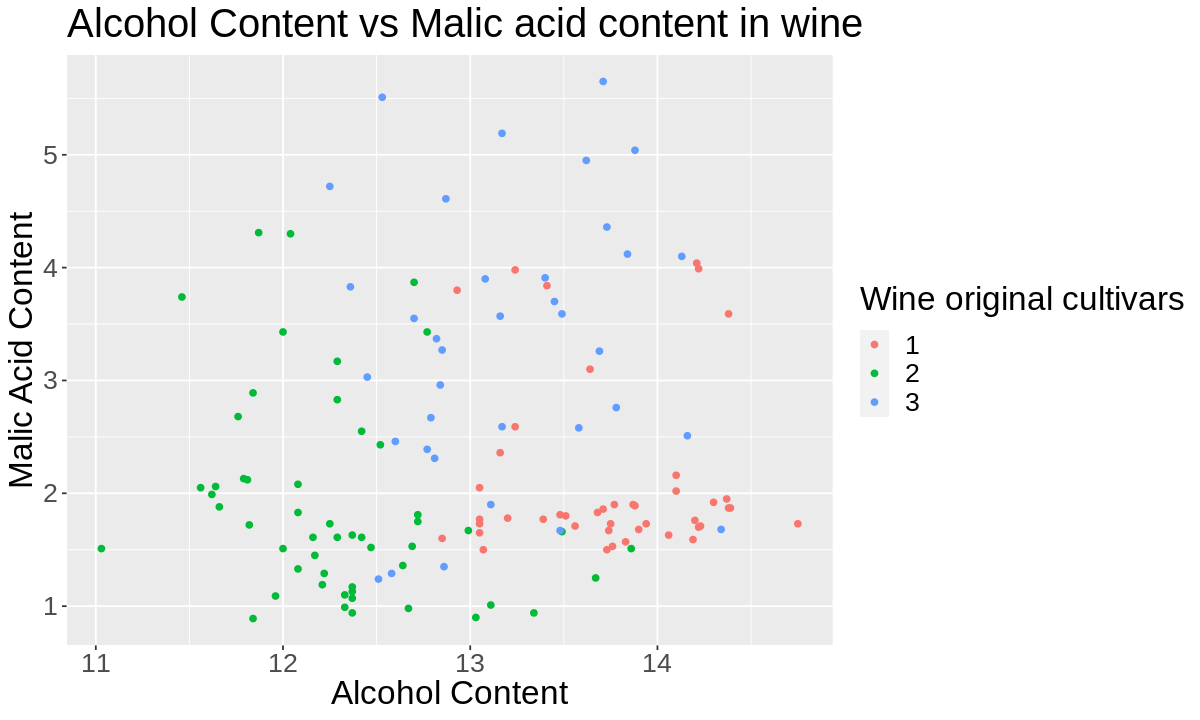

In [10]:
options(repr.plot.width=10, repr.plot.height=6)

wine_plot <- ggplot(wine_training, aes(x = Alcohol, y = Malic_Acid, color = as_factor(Cultivar))) +
            geom_point() +
            xlab("Alcohol Content") +
            ylab("Malic Acid Content") + 
            ggtitle("Alcohol Content vs Malic acid content in wine") +
            labs(color = "Wine original cultivars") +
            theme(text = element_text(size = 20))
wine_plot

This scatterplot plots the alcohol content of the wines against the malic acid content of the wine, while also showing the original cultivar of each point. This plot shows the relationship between alcohol content and malic acid content between each of the 3 cultivars.

**METHODS**

Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?

We will conduct our data analysis through classification:
    
1. Wrangle the data to rename columns (raw data did not include column names)
2. Split data into training data and testing data in a 3:1 ratio
3. Create knn_tune, setting the neighbor= tune(), in order to perform cross-validation later
4. Create wine_recipe, specificate the classifying object–cultivar, and the predictors in consideration for the model (every variable in the data except the cultivar). The data will also be scaled, baked, and prepped
5. Create cross-validation with 5 folds using the vfold_cv function
6. Create a wine_workflow, adding wine_recipe and knn_tune from step 3 and 4 
7. Create wine_fit, using the function tune_grid to fit the model into k values 1-150
8. Using a graph/table, we will identify the k value that provides the highest accuracy. It will be used to create our final classification model
    - Wine_best_spec (neighbor=most accurate k value)
    - Wine_best_fit (add recipe+model and fit wine_testing)
    - Wine_best (wine_best_fit + predict wine_testing + bind_cols + metrics)

For our data analysis, we will be using all 13 of the variables provided to us, as they are all numeric predictors, and contribute information about the wine content, which we can use to categorize and classify the wines.

There are a few ways we can visualize our results to plot our results:
- create many scatterplot graphs comparing the relationship of many combinations of different predictor variables, while showing their relationship to the original cultivars,
- or create a box plot.

**EXPECTED OUTCOME AND SIGNIFICANCE**

What do you expect to find?

- In this project, we expect to find ways to predict the original plant cultivars the wines were produced from.

What impact could such findings have?

- By comparing chemical observations, we would be able to determine whether or not a wine is authentically based in Italian, based on if it uses Italian-specific cultivars
- The determination of cultivar based on its chemical properties can be used as evidence as the first step to prove scandal / false advertisement / misconductions of companies or factories for wine production / identification of the wine based on its properties, etc.
    - For example, if a wine is being advertised as a specific type of cultivar, using the cultivar as a reason for unfair pricing, and the cultivar isn’t what they said it to be, the classification of its chemical property can be proposed as sample evidence to pursue further investigations
- It can also be helpful for future studies on the properties of these cultivars 

What future questions could this lead to?
- Do the chemical characteristics of these wines suggest that they originate from the same type of fruit, (ex. 3 different cultivars of grapes), or 3 distinct fruits?
- Are there any factors that can affect the chemical properties of the wine? If so, how? By how much?
    - Which properties would the factor(s) affect? Would it affect the prediction accuracy for classification model? 
    - If there are multiple factors, how would they influence the effects of one another? 
    - Examples of affecting factors:
        - could be time, storing environment (humidity, pressure, temperature, human handling, etc)
        - production method and details (fermentation method and time, fruit used (growth conditions, size, origin), etc. ). 
